In [63]:
import os
import zipfile
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [ ]:
# Set dataset path

DATA_DIR = r"YOUR DATA PATH"

train_path = os.path.join(DATA_DIR, 'train')
test_path = os.path.join(DATA_DIR, 'test')
val_path = os.path.join(DATA_DIR, 'val')

In [65]:
# Resize images, normalize pixel values, and apply random augmentations
image_size = 224  # ResNet input size

transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),# ResNet input size (224*224)
    transforms.RandomHorizontalFlip(),# Randomly flips images horizontally with a probability of 50%
    transforms.RandomRotation(10),  # Add random rotation
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # Add random affine transformation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Add color jittering
    transforms.ToTensor(),  # Converts the image into a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [66]:
# Dataset Loader

class ChestXrayDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in ['NORMAL', 'PNEUMONIA']:
            label_path = os.path.join(directory, label)
            for img_file in os.listdir(label_path):
                self.image_paths.append(os.path.join(label_path, img_file))
                self.labels.append(0 if label == 'NORMAL' else 1)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [67]:
# Load datasets
train_dataset = ChestXrayDataset(train_path, transform=transform_train)
val_dataset = ChestXrayDataset(val_path, transform=transform_test)
test_dataset = ChestXrayDataset(test_path, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [68]:
# Model Definition using Pre-trained ResNet-50
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features

for param in model.parameters():
    param.requires_grad = False
# Add dropout before the final fully connected layer
model.fc = nn.Sequential(
    nn.Dropout(p=0.3),  # Dropout layer with 50% probability
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512, 2)  # Binary classification: Normal vs Pneumonia
)  # Binary classification: Normal vs Pneumonia

In [69]:
# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

device

device(type='cuda')

In [71]:
def plot_training(history):
    """Plots training and validation loss/accuracy."""
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'r', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'b', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'r', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'b', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    plt.show()


In [72]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct_train / total_train * 100

    return epoch_loss, train_accuracy


In [73]:
def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / total_val * 100

    return val_loss, val_accuracy


In [74]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,num_epochs, patience, class_weights=None):
    best_val_loss = float('inf')
    stopping_counter = 0

    # Store training history
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    if class_weights is not None:
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    else:
         criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Store history for visualization
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            stopping_counter = 0  # Reset counter when improvement is found
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            stopping_counter += 1
            if stopping_counter >= patience:
                print("Early stopping triggered. Training stopped.")
                break
        scheduler.step(val_loss) # Step the scheduler based on the validation loss

    # Plot training progress
    plot_training(history)

    return model



In [75]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []


    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())  # Collect all labels
            all_preds.extend(preds.cpu().numpy())    # Collect 



    test_accuracy = correct / total * 100
     # Calculate metrics
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f'Test Accuracy: {test_accuracy:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'AUC: {auc:.4f}')
    print('Confusion Matrix:')
    print(cm)



Epoch [1/50], Loss: 0.3975, Acc: 85.95%, Val Loss: 1.5365, Val Acc: 56.25%
Epoch [2/50], Loss: 0.2653, Acc: 89.28%, Val Loss: 0.4529, Val Acc: 81.25%
Epoch [3/50], Loss: 0.2448, Acc: 89.90%, Val Loss: 1.2421, Val Acc: 56.25%
Epoch [4/50], Loss: 0.2646, Acc: 88.86%, Val Loss: 0.3662, Val Acc: 87.50%
Epoch [5/50], Loss: 0.2748, Acc: 89.44%, Val Loss: 0.4232, Val Acc: 87.50%
Epoch [6/50], Loss: 0.2416, Acc: 90.78%, Val Loss: 0.9279, Val Acc: 68.75%
Epoch [7/50], Loss: 0.3339, Acc: 89.30%, Val Loss: 0.6660, Val Acc: 68.75%
Epoch [8/50], Loss: 0.2217, Acc: 91.97%, Val Loss: 0.3644, Val Acc: 87.50%
Epoch [9/50], Loss: 0.2900, Acc: 89.63%, Val Loss: 0.5571, Val Acc: 68.75%
Epoch [10/50], Loss: 0.2290, Acc: 91.39%, Val Loss: 0.5577, Val Acc: 75.00%
Epoch [11/50], Loss: 0.2691, Acc: 90.59%, Val Loss: 0.2922, Val Acc: 87.50%
Epoch [12/50], Loss: 0.3064, Acc: 88.38%, Val Loss: 0.5195, Val Acc: 75.00%
Epoch [13/50], Loss: 0.2403, Acc: 90.76%, Val Loss: 0.3415, Val Acc: 87.50%
Epoch [14/50], Loss: 

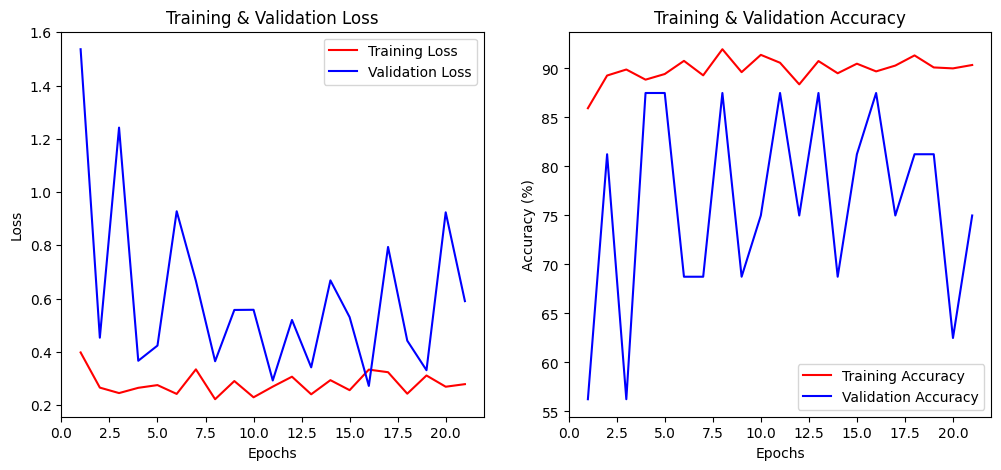

C:\Users\medom\AppData\Local\Temp\ipykernel_19884\2744020995.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Accuracy: 87.50%
Precision: 0.9021
Recall: 0.8974
F1-score: 0.8997
AUC: 0.8675
Confusion Matrix:
[[196  38]
 [ 40 350]]


In [76]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Train Model
model = train_model(model, train_loader, val_loader, criterion, optimizer,scheduler, num_epochs=50, patience=5)

# Load Best Model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate Model
evaluate_model(model, test_loader, device)

